In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split

In [ ]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.show()
    #Create samples without bias
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = torch.zeros(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAll)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples

In [ ]:
def build_distance_matrix_with_euclidean_distance(observation, centroids):
    # Here we are applying the mathematical operations of the Euclidean distance but operating through matrices
    observation_matrix = observation.repeat(centroids.shape[0],1)
    distances_matrix = centroids - observation_matrix
    distances_matrix_sum = torch.sum(distances_matrix, dim=1)
    distances_matrix_powed = torch.pow(distances_matrix_sum, 2)
    distances_matrix_final = torch.sqrt(distances_matrix_powed)
    return distances_matrix_final

In [ ]:
def KmeansImplementation(data, num_clusters, num_iterations):
  #Primero debemos escoger al azar num_clusters centroides
  indices = torch.randint(0, data.shape[0], (num_clusters,))
  centroids = data[indices]
  # print("Centroides escogidos aleatoriamente")
  # print(centroids)
  # print("------------")

  #cluster_association lo usaremos como una columna que haremos append al dataset para poner el cluster al que pertenece cada observacion
  cluster_association = torch.zeros(data.shape[0], 1)

  for iter in range(0,num_iterations):

    #Pintamos todos los puntos del dataset de color rosado
    plt.scatter(data[:, 0], data[:, 1], color = 'pink')
    plt.scatter(centroids[0, 0], centroids[0, 1], 200, color = 'blue', marker = 'x')
    plt.scatter(centroids[1, 0], centroids[1, 1], 200, color = 'red', marker = 'v')
    plt.show()

    #Creamos matriz de pesos
    weight_matriz = torch.zeros(data.shape[0], centroids.shape[0])
    #print(weight_matriz)

    w_idx = 0
    for observation_point in data :
      distances = build_distance_matrix_with_euclidean_distance(observation_point, centroids)
      # El centroide mas cercano al punto de observacion
      closest_centroid_observation = torch.argmin(distances).item()
      # Ponemos un 1 en la columna del centroide mas cercano
      weight_matriz[w_idx, closest_centroid_observation] = 1.0
      w_idx += 1

    #print(weight_matriz)

    
    for centroid_idx in range(0, centroids.shape[0]) :
      idxsOnes_Centroid = torch.nonzero(weight_matriz[:, centroid_idx]).reshape(-1)
      # print("Los indices de observaciones que pertenecen al centroide", centroid_idx, "son:", idxsOnes_Centroid)
      observations_closest_centroid = data[idxsOnes_Centroid]
      # print("Los datos que fueron asociados con el centroide", centroid_idx, "son:", observations_closest_centroid)
      #Ahora debo crear un vector "promedio" con todos las observaciones que estan cerca al centroide
      new_centroid = observations_closest_centroid.mean(dim=0)
      # print("El nuevo centroide es:", new_centroid)
      #seteamos el nuevo centroide
      centroids[centroid_idx] = new_centroid
      cluster_association[idxsOnes_Centroid] = centroid_idx
      
    # print("***********************")
    # print("Los nuevos centroides son:", centroids)
  
  #print("Cluster association", cluster_association)
  final_clustered_data = torch.cat((cluster_association, data), 1)


  #print(final_clustered_data[final_clustered_data[:, 0] == 1])
  cls_0 = final_clustered_data[final_clustered_data[:, 0] == 0]
  cls_1 = final_clustered_data[final_clustered_data[:, 0] == 1]
  plt.scatter(cls_0[:, 1], cls_0[:, 2], color = 'gray')
  plt.scatter(cls_1[:, 1], cls_1[:, 2], color = 'black')
  plt.scatter(centroids[0, 0], centroids[0, 1], 200, color = 'blue', marker = 'x')
  plt.scatter(centroids[1, 0], centroids[1, 1], 200, color = 'red', marker = 'v')
  plt.show()

  # print("La matriz final con los datos asociados al cluster y centroides es", final_clustered_data)
  return final_clustered_data



def test_Kmeans(targets, samples, num_clusters, num_iterations):
  final_data_clustered = KmeansImplementation(samples, num_clusters, num_iterations)
  targets_reshape = targets.reshape(-1)
  amount_right_estimations = (final_data_clustered[:, 0] == targets_reshape).sum()
  accuracy = amount_right_estimations / targets.shape[0]
  return accuracy.item()


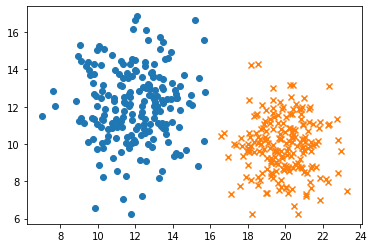

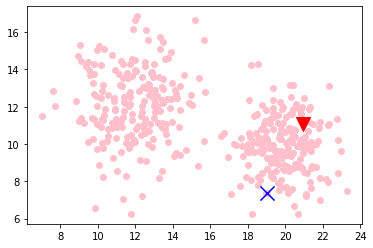

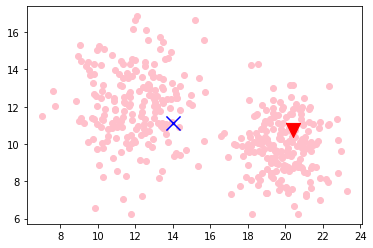

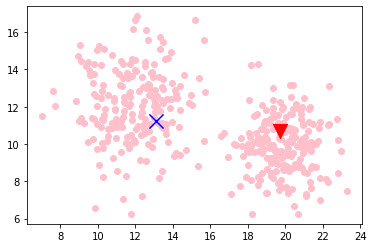

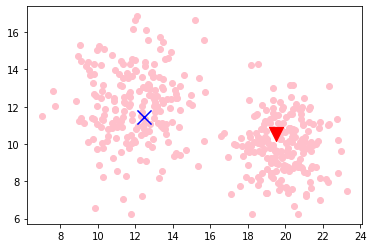

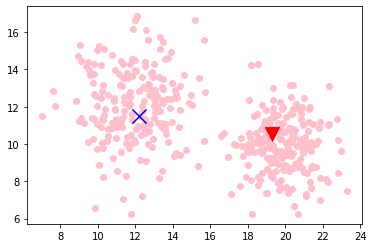

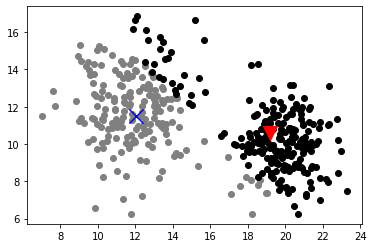

The accuracy for run # 0 is: 0.0949999988079071


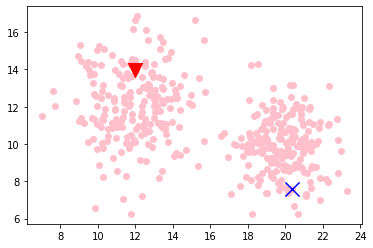

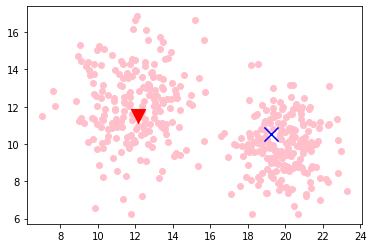

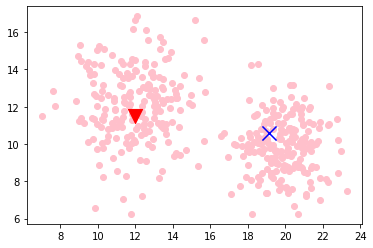

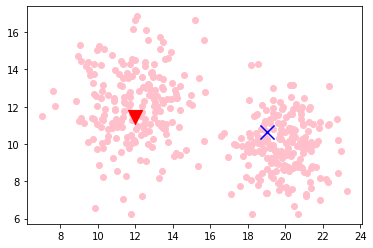

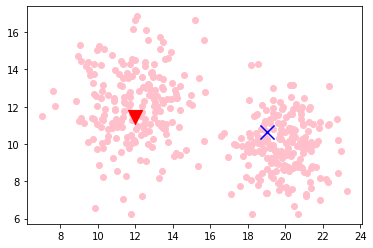

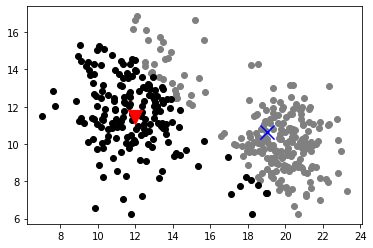

The accuracy for run # 1 is: 0.8949999809265137


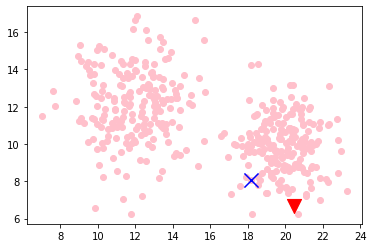

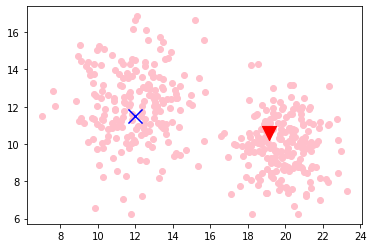

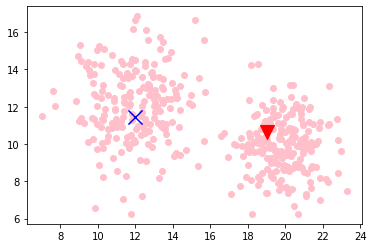

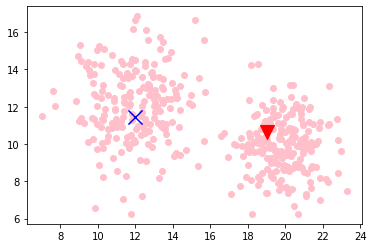

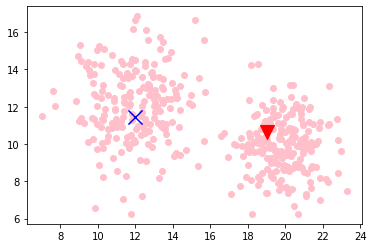

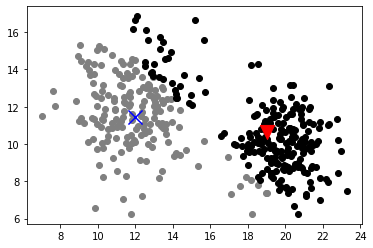

The accuracy for run # 2 is: 0.10499999672174454


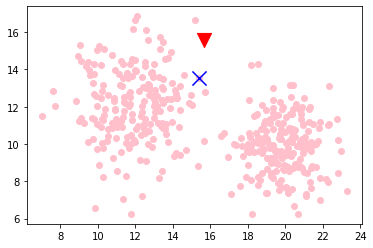

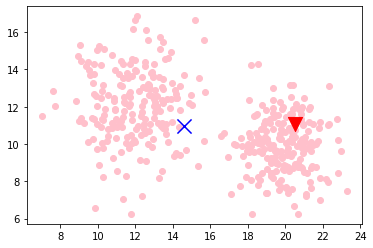

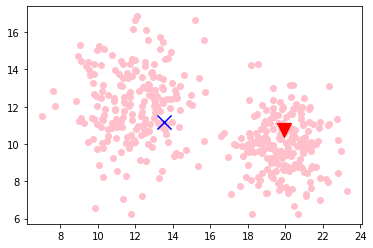

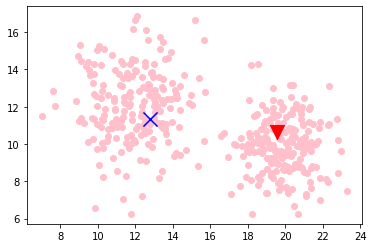

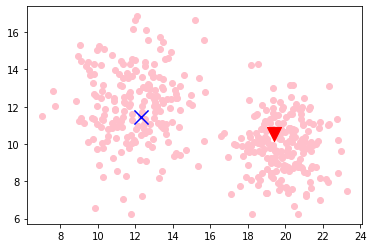

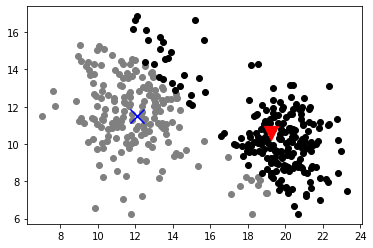

The accuracy for run # 3 is: 0.0925000011920929


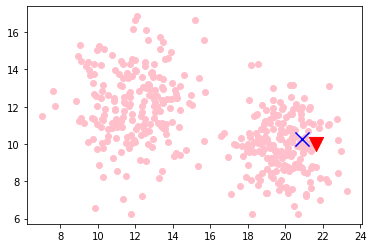

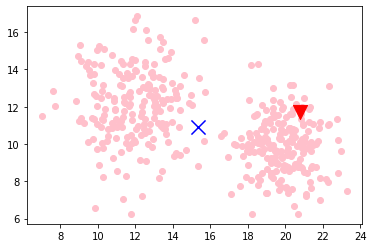

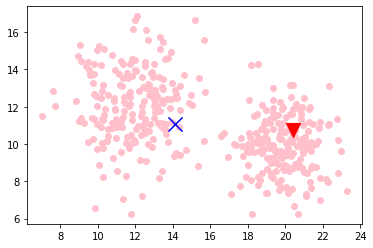

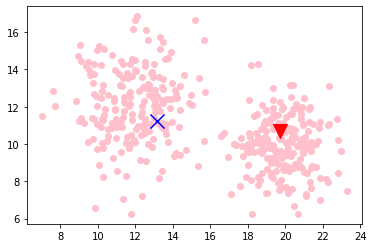

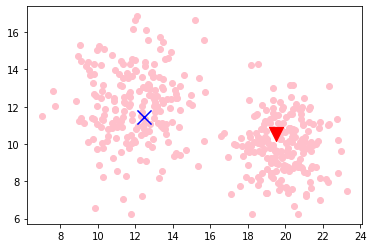

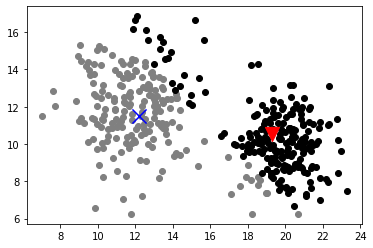

The accuracy for run # 4 is: 0.09000000357627869


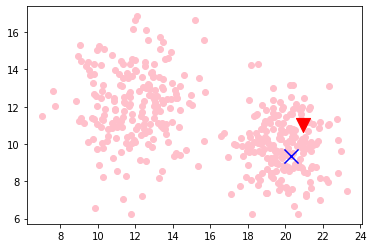

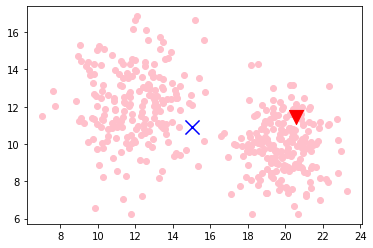

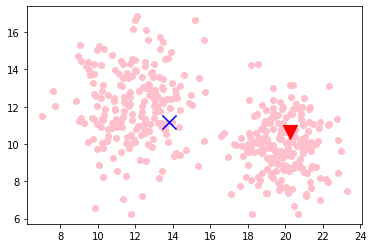

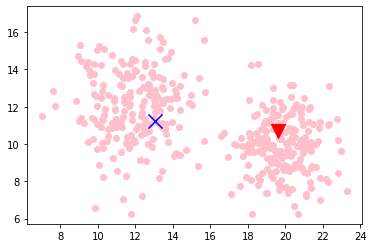

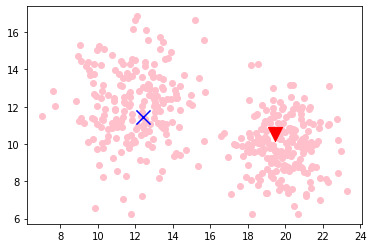

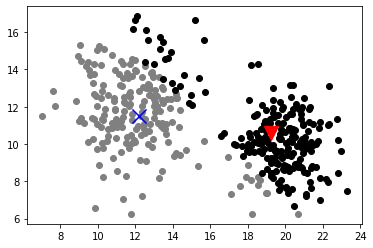

The accuracy for run # 5 is: 0.0949999988079071


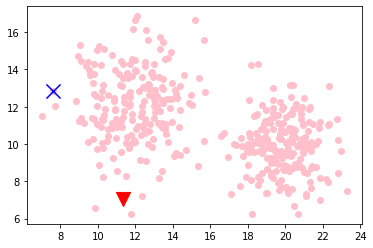

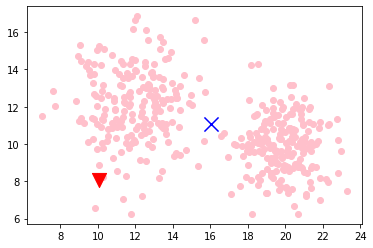

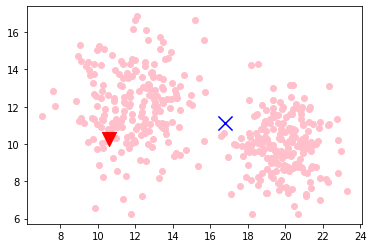

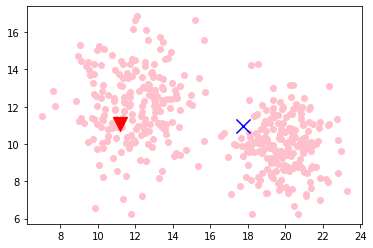

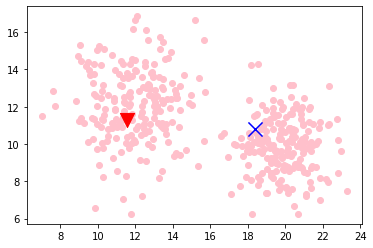

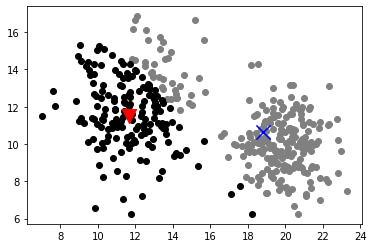

The accuracy for run # 6 is: 0.8899999856948853


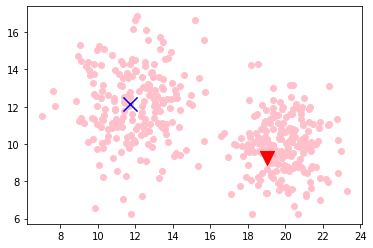

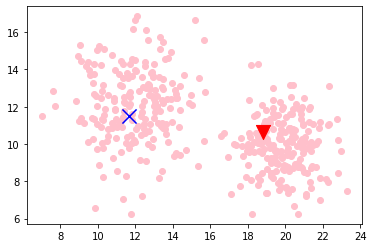

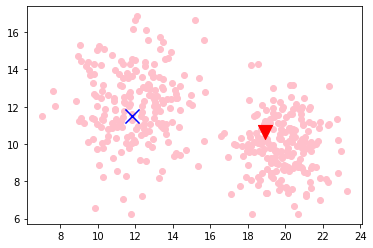

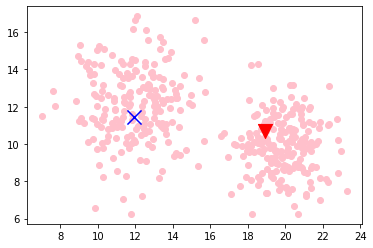

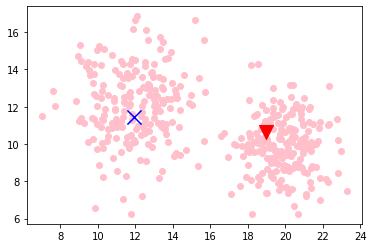

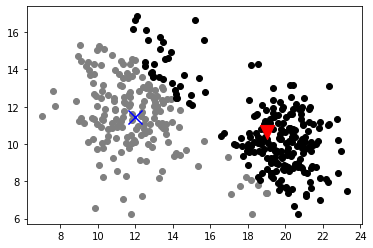

The accuracy for run # 7 is: 0.10750000178813934


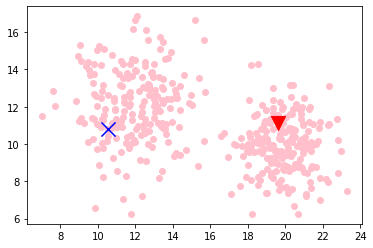

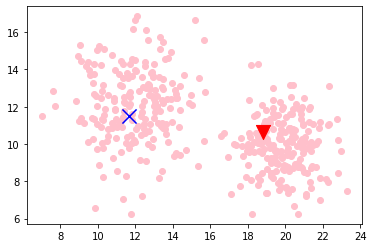

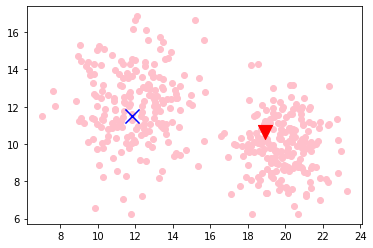

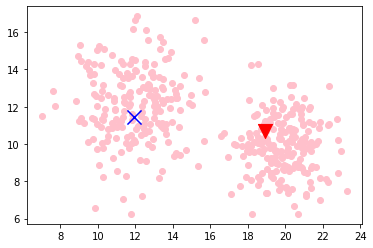

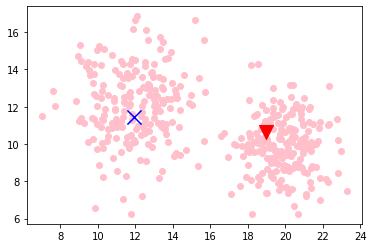

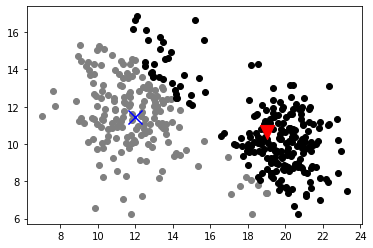

The accuracy for run # 8 is: 0.10750000178813934


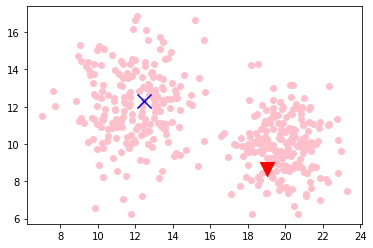

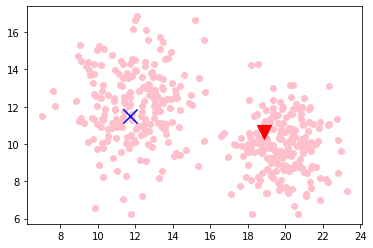

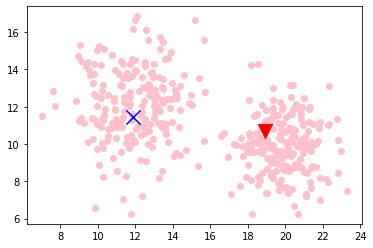

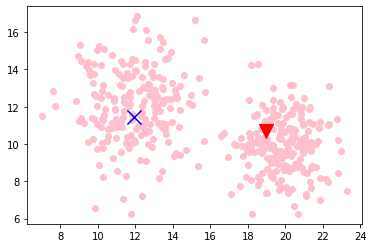

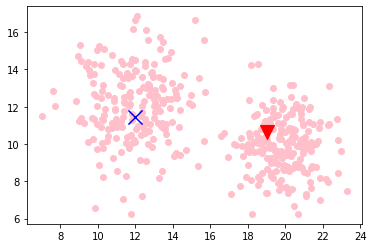

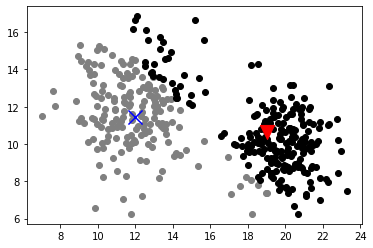

The accuracy for run # 9 is: 0.10499999672174454


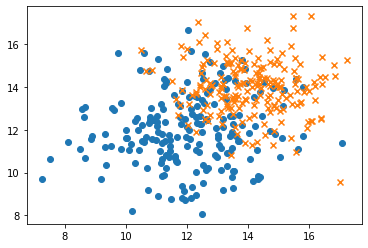

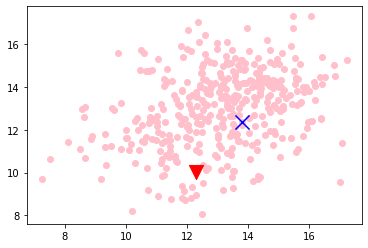

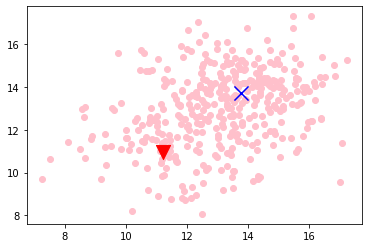

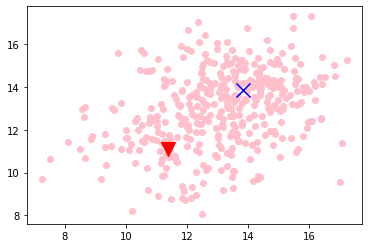

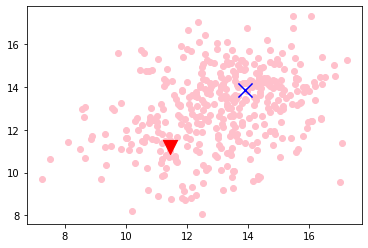

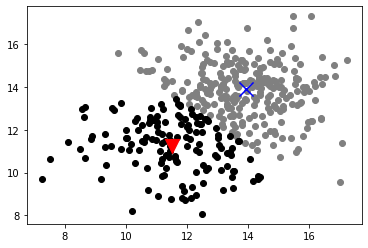

The accuracy for run # 0 is: 0.8125


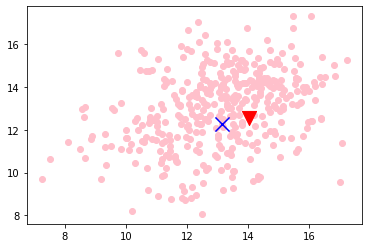

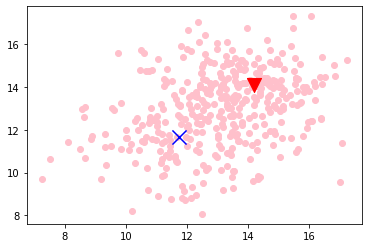

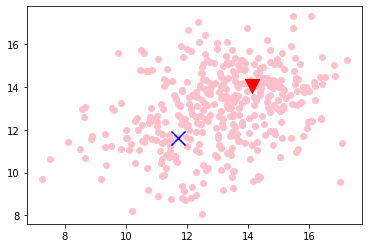

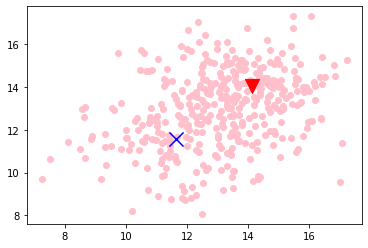

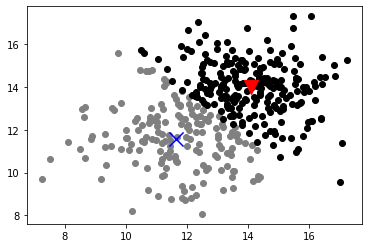

The accuracy for run # 1 is: 0.17749999463558197


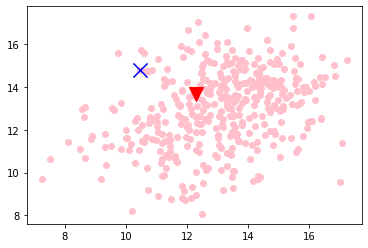

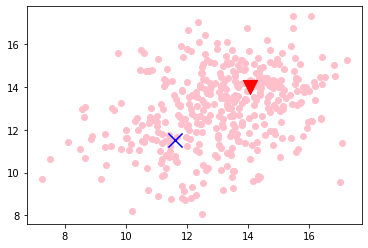

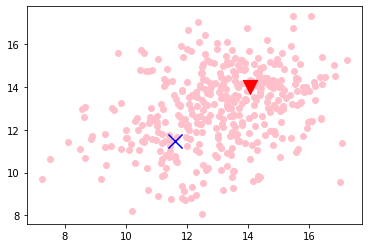

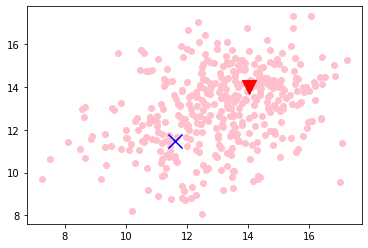

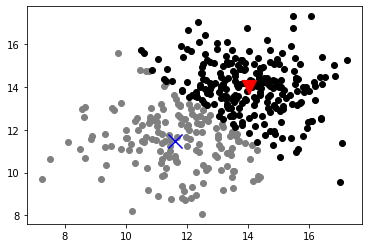

The accuracy for run # 2 is: 0.18000000715255737


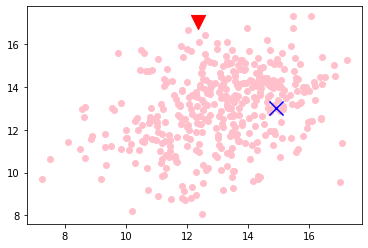

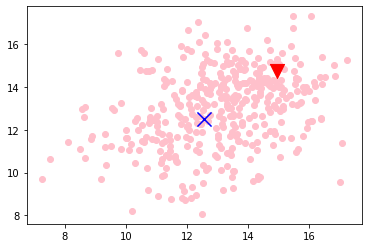

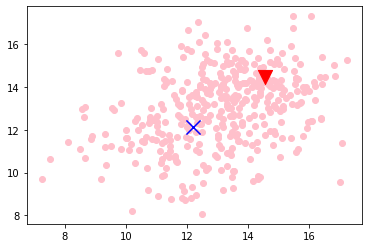

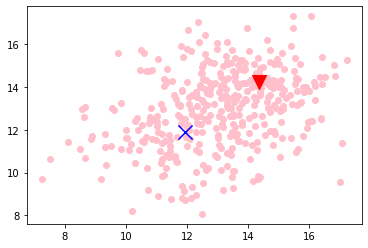

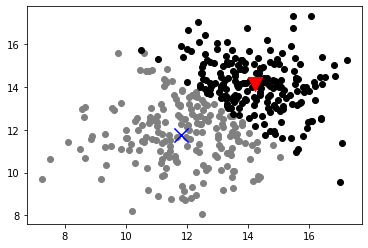

The accuracy for run # 3 is: 0.16750000417232513


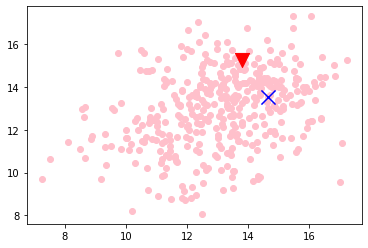

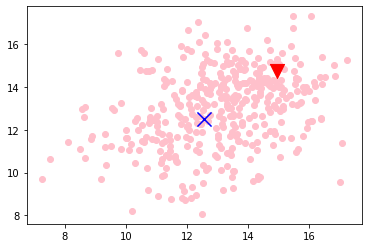

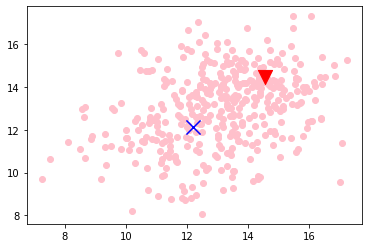

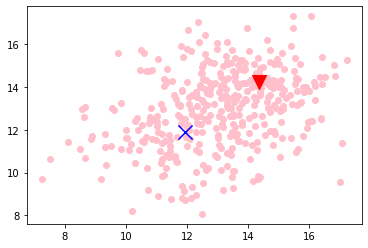

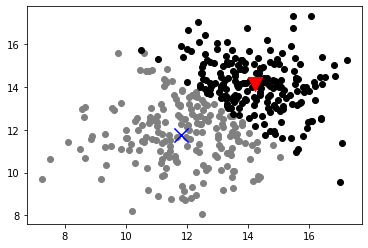

The accuracy for run # 4 is: 0.16750000417232513


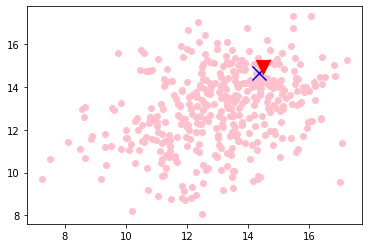

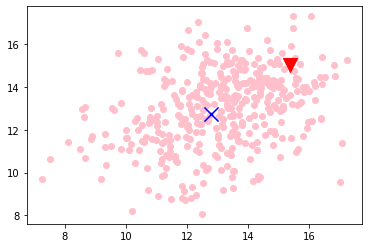

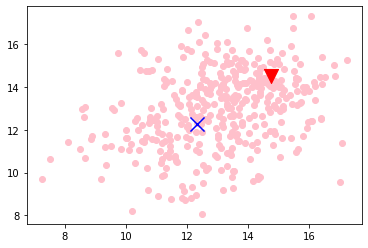

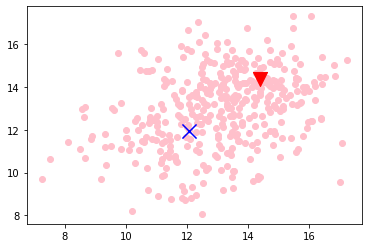

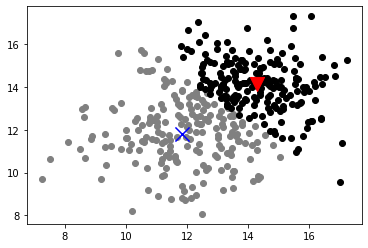

The accuracy for run # 5 is: 0.16750000417232513


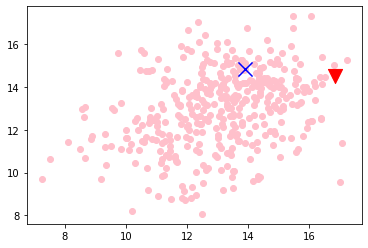

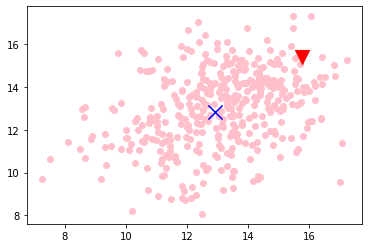

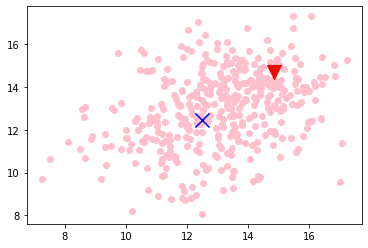

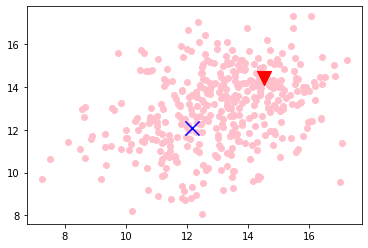

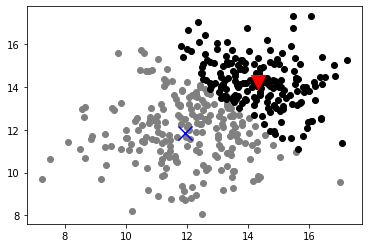

The accuracy for run # 6 is: 0.1899999976158142


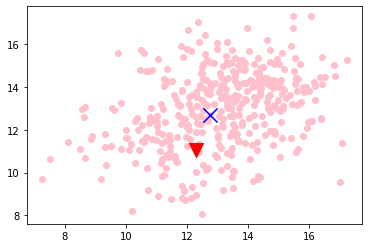

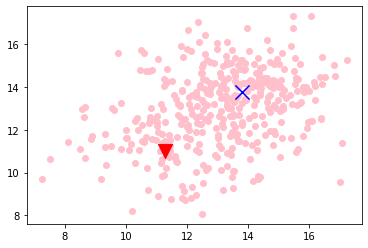

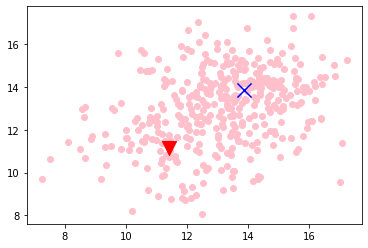

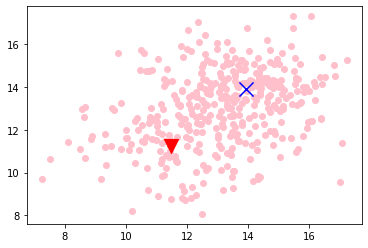

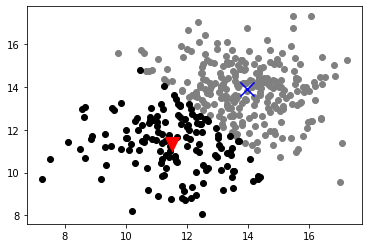

The accuracy for run # 7 is: 0.8174999952316284


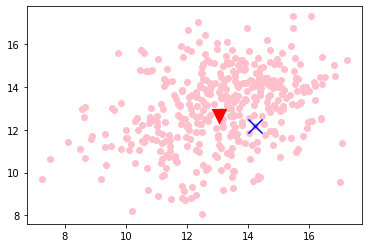

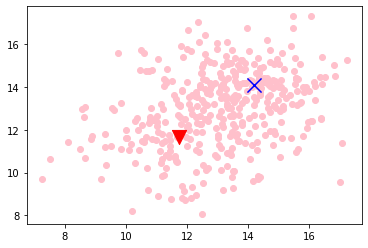

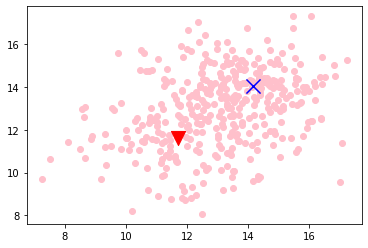

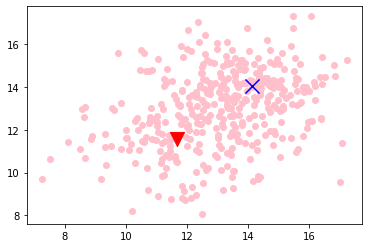

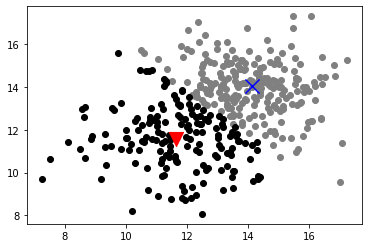

The accuracy for run # 8 is: 0.8199999928474426


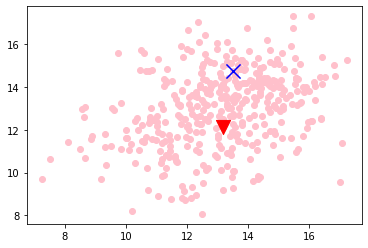

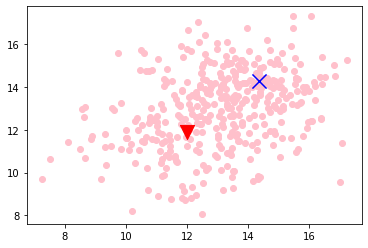

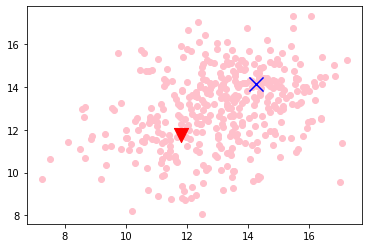

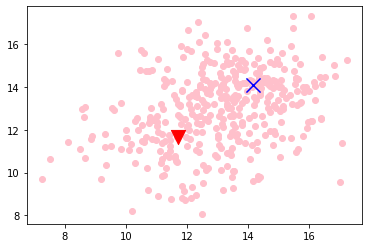

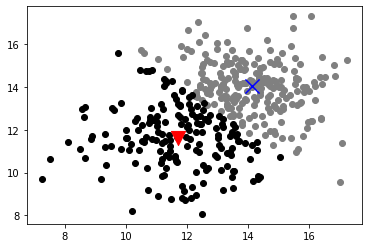

The accuracy for run # 9 is: 0.8224999904632568


In [ ]:
"""
Main function
"""
def main():
    
    (TargetsAllSeparated, SamplesAllSeparated) = createData(numberSamplesPerClass = 200, mean1 = [12,12], mean2 = [20, 10], stds1 = [3, 3], stds2 = [2, 2])

    for i in range(0, 10):
      acc = test_Kmeans(TargetsAllSeparated, SamplesAllSeparated, 2, 5)
      print("The accuracy for run #",  i, "is:", acc)


    (TargetsAllJoined, SamplesAllJoined) = createData(numberSamplesPerClass = 200, mean1 = [12,12], mean2 = [14, 14], stds1 = [3, 3], stds2 = [2, 2])


    for i in range(0, 10):
      acc = test_Kmeans(TargetsAllJoined, SamplesAllJoined, 2, 4)
      print("The accuracy for run #",  i, "is:", acc)
    

    
    
main()